In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sonar-dataset-csv/sonar_dataset.csv


## Dropout

Dropout is a **regularization technique** that works by temporarily and randomly disabling a fraction of the neurons in a layer during each training step.

### 1. Mechanism
* **During Training:** For every training batch, each neuron in a specified layer has a probability $p$ (e.g., $50\%$) of being temporarily **ignored** (set to zero). This means it won't contribute to the forward pass and won't participate in the backward pass.
* **The Ensemble Effect:** Because the network changes on every training step, no single neuron can rely on the presence of any other specific neuron. This forces the network to learn a more robust, distributed representation across all remaining neurons, effectively training a vast ensemble of different "thinned" networks.
* **During Testing/Inference:** Dropout is **turned off**. To compensate for the fact that every neuron is now active (receiving more input than during training), the output of the dropout layer is typically **scaled down** by the dropout probability $p$ (e.g., if $p=0.5$, the weights are multiplied by $0.5$).

### 2. Purpose
Dropout is an extremely effective way to **reduce co-adaptation** between neurons.

<br>

## Regularization (L1 and L2)

Traditional regularization (L1 and L2) works by adding a **penalty term** to the model's overall **loss function** during training. This penalty is proportional to the magnitude (size) of the model's weights.

### 1. Mechanism
The original loss function is modified:

$$\text{New Loss} = \text{Original Loss} + \text{Regularization Term}$$

* **L2 Regularization (Weight Decay):** The penalty is based on the **square** of the weights. It encourages weights to be **small but non-zero**. This leads to smoother models where no single feature or weight dominates the prediction.
    $$\text{Regularization Term} = \lambda \sum_{i} w_{i}^{2}$$
* **L1 Regularization:** The penalty is based on the **absolute value** of the weights. This method has a tendency to push the weights of less important features **all the way to zero**, effectively performing **feature selection**.
    $$\text{Regularization Term} = \lambda \sum_{i} |w_{i}|$$

### 2. Purpose
Regularization reduces the complexity of the model by **constraining the magnitude of the weights**. This prevents the model from assigning extremely large weights to specific features in the training data, leading to better generalization.

<br>

## Key Differences

| Feature | Dropout | L1 / L2 Regularization |
| :--- | :--- | :--- |
| **Method** | **Randomly deactivates neurons** during training. | **Adds a penalty term** to the loss function based on weight size. |
| **Effect** | Prevents **co-adaptation** of neurons; trains an ensemble. | Prevents **overly large weights**; simplifies the model. |
| **Mechanism** | Applied as a **layer** between other layers (e.g., `tf.keras.layers.Dropout`). | Applied to the **weights** of a specific layer (e.g., `kernel_regularizer` in Keras). |
| **State at Test** | Turned **off** (outputs are scaled). | **Active** (weights remain small). |

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [26]:
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("/kaggle/input/sonar-dataset-csv/sonar_dataset.csv", header=None)
df.sample(5)

0       1       2       3       4       5       6       7       8   \
201  0.0335  0.0258  0.0398  0.0570  0.0529  0.1091  0.1709  0.1684  0.1865   
151  0.0231  0.0315  0.0170  0.0226  0.0410  0.0116  0.0223  0.0805  0.2365   
142  0.0526  0.0563  0.1219  0.1206  0.0246  0.1022  0.0539  0.0439  0.2291   
192  0.0056  0.0267  0.0221  0.0561  0.0936  0.1146  0.0706  0.0996  0.1673   
77   0.0336  0.0294  0.0476  0.0539  0.0794  0.0804  0.1136  0.1228  0.1235   

         9   ...      51      52      53      54      55      56      57  \
201  0.2660  ...  0.0120  0.0039  0.0053  0.0062  0.0046  0.0045  0.0022   
151  0.2461  ...  0.0125  0.0036  0.0123  0.0043  0.0114  0.0052  0.0091   
142  0.1632  ...  0.0339  0.0149  0.0335  0.0376  0.0174  0.0132  0.0103   
192  0.1859  ...  0.0072  0.0055  0.0074  0.0068  0.0084  0.0037  0.0024   
77   0.0842  ...  0.0150  0.0111  0.0032  0.0035  0.0169  0.0137  0.0015   

         58      59  60  
201  0.0005  0.0031   M  
151  0.0008  0.0092   M  
142  0.0364  0.0208   M  
192  0.0034  0.0007   M  
77   0.0069  0.0051   R  

[5 rows x 61 columns]

In [27]:
df.shape

(208, 61)

In [28]:
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
     ..
56    0
57    0
58    0
59    0
60    0
Length: 61, dtype: int64

In [29]:
df[60].value_counts()

60
M    111
R     97
Name: count, dtype: int64

In [30]:
df.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
56    float64
57    float64
58    float64
59    float64
60     object
Length: 61, dtype: object

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

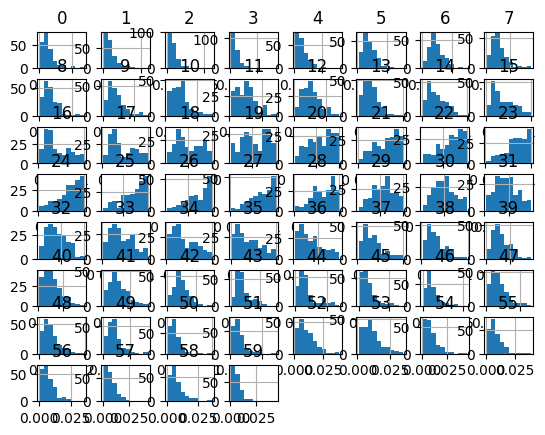

In [31]:
df.hist()

In [32]:
X = df.drop(60, axis=1)
y = df[60]

y

0      R
1      R
2      R
3      R
4      R
      ..
203    M
204    M
205    M
206    M
207    M
Name: 60, Length: 208, dtype: object

In [33]:
# As y contains text data, we have to encode it using one-hot-encoder

y = pd.get_dummies(y, drop_first=True)
y.sample(5)

y.dtypes

R    bool
dtype: object

In [34]:
y.value_counts()

R    
False    111
True      97
Name: count, dtype: int64

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [36]:
X_train.shape, y_train.shape

((156, 60), (156, 1))

In [37]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(60, input_shape=(60,), activation='relu'),
    
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(17, activation='relu'),
    
    keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer = 'Adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model.fit(X_train, y_train, epochs=100, batch_size=8)

Epoch 1/100


2025-10-07 02:27:20.509141: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5231 - loss: 0.6908
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6000 - loss: 0.6549 
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6724 - loss: 0.6358 
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6909 - loss: 0.6143 
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7779 - loss: 0.5793 
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7448 - loss: 0.5364 
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7613 - loss: 0.5028 
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7708 - loss: 0.4768 
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.3979 
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7103 - loss: 0.5227 
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8152 - loss: 0.4148 
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0

In [38]:
model.evaluate(X_test, y_test)

# causing overfittiing

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 1.1770 


[1.090033769607544, 0.75]

In [41]:
y_pred = model.predict(X_test)
print(y_pred[:5])

# round the y_pred to the nearest int 0 or 1
y_pred = np.round(y_pred)
print(y_pred[:5])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[2.1800991e-13]
 [9.9881715e-01]
 [9.8494279e-01]
 [6.4433090e-07]
 [9.9999958e-01]]
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [43]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.85      0.72      0.78        32
         1.0       0.64      0.80      0.71        20

    accuracy                           0.75        52
   macro avg       0.75      0.76      0.75        52
weighted avg       0.77      0.75      0.75        52



In [47]:
# Now introducinng dropout layer

import tensorflow as tf
from tensorflow import keras

modeld = keras.Sequential([
    keras.layers.Dense(60, input_shape=(60,), activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(17, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

modeld.compile(
    optimizer = 'Adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

modeld.fit(X_train, y_train, epochs=100, batch_size=8)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4355 - loss: 0.7614
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4856 - loss: 0.7212
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5050 - loss: 0.7316
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5498 - loss: 0.6963
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5421 - loss: 0.6955
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5840 - loss: 0.6677
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5439 - loss: 0.6666
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5319 - loss: 0.6933
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4696 - loss: 0.7188
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5091 - loss: 0.6924
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5861 - loss: 0.6981
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy:

In [48]:
modeld.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7396 - loss: 0.5129 


[0.47800305485725403, 0.75]

In [49]:
y_pred_d = modeld.predict(X_test)
print(y_pred_d[:5])

y_pred_d = np.round(y_pred_d)
print(y_pred_d[:5])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[[5.3645286e-04]
 [8.9030296e-01]
 [8.9013559e-01]
 [3.3591885e-02]
 [9.9915844e-01]]
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [50]:
print(classification_report(y_pred_d, y_test))

# f1-score is very good in my condiciton

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75        26
         1.0       0.76      0.73      0.75        26

    accuracy                           0.75        52
   macro avg       0.75      0.75      0.75        52
weighted avg       0.75      0.75      0.75        52



## 1. Check Class Balance (Support)

The first thing to notice is the **`support`** column:

* **Class 0.0 Support:** 26
* **Class 1.0 Support:** 26
* **Total:** 52

**Analysis:** The test set is **perfectly balanced**. The model was evaluated on the exact same number of samples for each class. This means **Accuracy** is a reliable metric, as the model can't simply guess the majority class to inflate its score.

<br>

## 2. Evaluate Overall Performance (Accuracy)

* **Accuracy:** $0.75$ (or 75%)

**Analysis:** The model correctly predicted the class for **75%** of the 52 total samples. This is a solid starting point, indicating the model is performing significantly better than random guessing ($50\%$).

<br>

## 3. Analyze Performance Per Class (Precision, Recall, F1-Score)

Since the classes are balanced, we can look directly at the metrics for each class.

| Class | Precision | Recall | F1-Score |
| :---: | :---: | :---: | :---: |
| **0.0** | $0.74$ | $0.77$ | $0.75$ |
| **1.0** | $0.76$ | $0.73$ | $0.75$ |

### A. Precision and False Positives (FP)

* **Precision (0.0):** $0.74$
    * **Meaning:** When the model predicted a sample was Class 0.0, it was correct **74% of the time**. The other $26\%$ were **False Positives (FP)** relative to class 0.0.
* **Precision (1.0):** $0.76$
    * **Meaning:** When the model predicted a sample was Class 1.0, it was correct **76% of the time**. This is slightly better than Class 0.0 precision.

### B. Recall and False Negatives (FN)

* **Recall (0.0):** $0.77$
    * **Meaning:** The model successfully identified **$77\%$** of all actual Class 0.0 samples. It missed $23\%$ of the actual Class 0.0 samples (**False Negatives (FN)**).
* **Recall (1.0):** $0.73$
    * **Meaning:** The model successfully identified **$73\%$** of all actual Class 1.0 samples. It missed $27\%$ of the actual Class 1.0 samples.

### C. F1-Score (The Balance)

* **F1-Score (0.0):** $0.75$
* **F1-Score (1.0):** $0.75$

**Analysis:** The F1-scores are identical, which means the model has an **equally balanced performance** across both classes. In both cases, the model is slightly better at **Recall** for Class 0.0 (it finds more of them) but slightly better at **Precision** for Class 1.0 (when it predicts 1.0, it's slightly more certain). The difference is minor.

<br>

## 4. Final Summary

The model demonstrates **consistent and balanced performance** across both classes:

* **Strengths:** The metrics are uniform (all near $0.75$) and the model handles both classes equally well, making it a reliable general-purpose classifier for this data.
* **Areas for Improvement:** An F1-score of $0.75$ means there's still a $25\%$ error rate. To improve, you would focus on either:
    1.  **Engineering better features** to reduce overall error.
    2.  **Adjusting the classification threshold** if you need to prioritize finding *more* samples (increase Recall) or being *more certain* about positive predictions (increase Precision).